# Import stuff

In [8]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Load dataset

In [9]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# tf.distribute

In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/cpu:0", "/cpu:1", "/cpu:2"])

with mirrored_strategy.scope():
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    # model.summary()

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=3,
                    validation_data=(test_images, test_labels))

1563/1563 [==============================] - 114s 73ms/step - loss: 1.1585 - accuracy: 0.5929 - val_loss: 1.1389 - val_accuracy: 0.5928

In [5]:
mirrored_strategy.num_replicas_in_sync

3

313/313 - 3s - loss: 0.9819 - accuracy: 0.6589


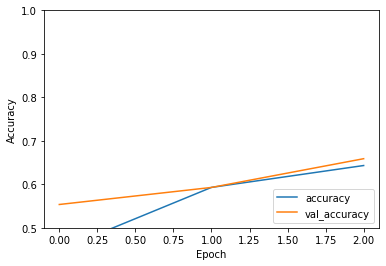

In [6]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [7]:
print(test_acc)

0.6589000225067139
